## Loading Dataset and Importing Libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gensim
import keras
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Sequential
from keras.models import Model
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle # we can also shuffle in input_func with tensorflow
warnings.filterwarnings("ignore")
from collections import Counter
nltk.download("stopwords")
# nltk.download("punkt")

%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to C:\Users\Umair
[nltk_data]     Gillani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('SEM_KeyWord_Dataset.csv')

In [3]:
df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.00%,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.20%,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.00%,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.00%,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.00%,0.0,0.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356054 entries, 0 to 356053
Data columns (total 9 columns):
Date                356054 non-null int64
Market              356054 non-null object
Keyword             355575 non-null object
Average.Position    353018 non-null float64
CPC                 353018 non-null float64
Clicks              353018 non-null float64
CTR                 353018 non-null object
Impressions         353018 non-null float64
Cost                353018 non-null float64
dtypes: float64(5), int64(1), object(3)
memory usage: 24.4+ MB


In [5]:
df.describe()

,Date,Average.Position,CPC,Clicks,Impressions,Cost
count,3.560540e+05,353018.000000,353018.000000,353018.000000,3.530180e+05,3.530180e+05
mean,2.012269e+07,0.611737,14.285071,439.052699,1.874365e+04,3.598259e+03
std,3.577676e+03,0.643839,37.858433,7559.532663,2.970826e+05,5.718301e+04
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,2.012102e+07,1.000000,1.100000,2.120000,1.290000e+02,8.070000e+00
75%,2.012122e+07,1.000000,12.100000,35.230000,1.571000e+03,3.749975e+02
max,2.013021e+07,12.000000,632.730000,441963.500000,1.566667e+07,3.269108e+06


## Data Pre-processing:

In [6]:
df['CTR'] = df['CTR'].apply(lambda x: float(str(x).replace('%', ''))) # remove extra character string

df = df.dropna() # drop the null values 

# df['Market'] = pd.get_dummies(df['Market']) # set dummies for market feature (binary)

df.head() # check head

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.0,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.2,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.0,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.0,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.0,0.0,0.00


In [7]:
# Let's quickly make sure we are not left with any null value in out data set
#  plt.figure(figsize = (12,6))
# sns.heatmap(df.isnull(), cmap = 'YlGnBu')
df.isnull().any()

Date                False
Market              False
Keyword             False
Average.Position    False
CPC                 False
Clicks              False
CTR                 False
Impressions         False
Cost                False
dtype: bool

In [8]:
# Now as we can see we have a lot of values that are "zeros"
# having those values in our data set make the model not learn properly and might overfit
# due to the repeated nature. So we might wanna eliminate those zero values 
# from our data set 

mapped_market = {'US-Market': 1, 'UK-Market': -1}

new_df = df[df['CPC'] != 0]
new_df['Market'] = new_df["Market"].map(mapped_market) # map the market values with 1's and 0's
new_df.info() # new data set with "CPC" not equals to "Zero"
new_df.head(10)

# Now we have 2 data sets
# one with all the observations i.e with "CPC" having zero values
# other, having "CPC" not equals to zero

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203595 entries, 1 to 356039
Data columns (total 9 columns):
Date                203595 non-null int64
Market              203595 non-null int64
Keyword             203595 non-null object
Average.Position    203595 non-null float64
CPC                 203595 non-null float64
Clicks              203595 non-null float64
CTR                 203595 non-null float64
Impressions         203595 non-null float64
Cost                203595 non-null float64
dtypes: float64(6), int64(2), object(1)
memory usage: 15.5+ MB


,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
1,20120524,1,agile management software,1.0,1.20,21.22,8.2,260.0,25.45
9,20120524,1,android app developers,1.0,0.66,23.31,8.6,270.0,15.31
13,20120524,1,android application developer,1.0,1.02,46.92,8.6,546.0,47.77
14,20120524,1,android app developer,1.0,1.30,147.46,6.0,2469.0,191.99
17,20120524,1,mobile applications developers,1.0,0.57,21.69,8.3,260.0,12.31
19,20120524,1,cloud computing for dummies,1.0,0.50,37.89,11.4,330.0,19.10
24,20120524,1,apps development,1.0,0.69,23.69,5.5,433.0,16.25
27,20120524,1,mobile apps developers,1.0,2.53,22.94,4.3,529.0,58.04
28,20120524,1,joomla designers,1.0,1.37,17.84,6.6,268.0,24.36
44,20120524,1,ink 8560,1.0,1.59,0.26,0.1,216.0,0.41


In [9]:
new_df = shuffle(new_df)
new_df.head()

new_df['Market'].nunique()

2

In [10]:
new_df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
102314,20130125,1,lil kim,1.0,0.03,3.81,1.4,273.0,0.11
102357,20130125,1,world cup,1.0,0.14,11.75,1.1,1044.0,1.60
18792,20120711,1,san diego dui lawyer,1.0,2.14,26.54,6.9,382.0,56.93
321423,20121216,-1,stock images,1.0,7.21,89.44,2.1,4283.0,645.14
140633,20120914,1,apply for credit cards,1.1,114.03,12.77,0.9,1458.0,1456.23


In [11]:
nltk.download("stopwords") # downloading all the stopwords for English from nltk

[nltk_data] Downloading package stopwords to C:\Users\Umair
[nltk_data]     Gillani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stopwords = set(stopwords.words("english"))

In [13]:
def remove_stops(example_sent):
    word_tokens = example_sent.split()
    filtered_sentence = ' '.join([word for word in word_tokens if not word in stopwords])
    return filtered_sentence

new_df['Keyword'] = new_df['Keyword'].apply(remove_stops)
new_df.head()

cleaned_list = []

for word in list(new_df["Keyword"]):
    for w in word.split():
        cleaned_list.append(w)
        
len(cleaned_list) # Length of the words has reduced to 480702 from 501285 after removing stop words!

480702

## Data Normalization:

In [14]:
new_df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
102314,20130125,1,lil kim,1.0,0.03,3.81,1.4,273.0,0.11
102357,20130125,1,world cup,1.0,0.14,11.75,1.1,1044.0,1.60
18792,20120711,1,san diego dui lawyer,1.0,2.14,26.54,6.9,382.0,56.93
321423,20121216,-1,stock images,1.0,7.21,89.44,2.1,4283.0,645.14
140633,20120914,1,apply credit cards,1.1,114.03,12.77,0.9,1458.0,1456.23


In [26]:
scaler = MinMaxScaler()
scaler.fit(new_df[['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks']])
scaled_features = scaler.transform(new_df[['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks']])
scaled_df = pd.DataFrame(data = scaled_features, columns = ['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'])
scaled_df.head()
X = data
y = df['Clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
# Randome Linear Regression Test
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Prediction Accuracy: {0:0.3f}".format(metrics.r2_score(y_test, predictions) * 100))

Prediction Accuracy: 72.108


## Data Visualization:

In [17]:
#plt.figure(figsize = (12,6))
#sns.scatterplot(x = new_df['CTR'], y = new_df['Clicks'])

In [18]:
#plt.figure(figsize = (12,6))
#sns.relplot(x = 'CPC', y = 'Clicks', data = new_df, hue = 'Market')

In [19]:
# Lets quickly check how our target variable is distribted 
#plt.figure(figsize = (12,6))
#sns.distplot(new_df['Clicks'], bins = 40, kde = True)

In [20]:
#clicks = list(new_df['Clicks'])

#max(clicks)

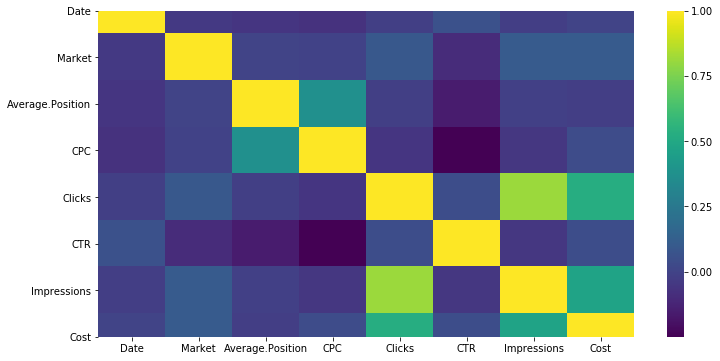

In [21]:
corr = new_df.corr()

plt.figure(figsize = (12,6))
sns.heatmap(data = corr, cmap = 'viridis')

In [22]:
#sns.distplot((y_test-predictions), bins = 30)

## Correlations:

In [23]:
corr = new_df.corr()

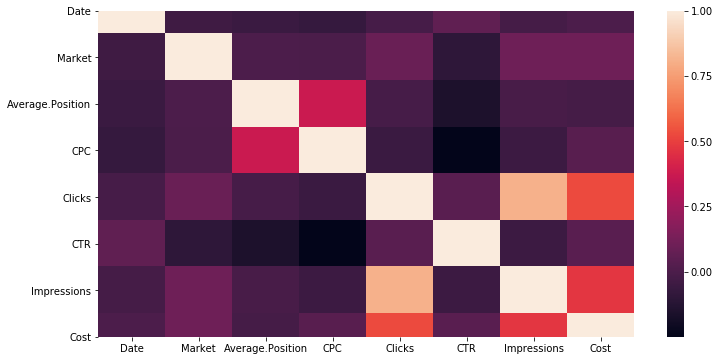

In [24]:
plt.figure(figsize = (12,6))
sns.heatmap(corr)

In [25]:
new_df['Clicks'].corr(new_df['Cost'])

0.5307991295567503

## Keras Test:

In [27]:
scaled_df.head()

,Date,CPC,Market,CTR,Impressions,Cost,Clicks
0,0.991020,0.000032,1.0,0.059072,0.000071,3.849976e-07,0.000043
1,0.991020,0.000205,1.0,0.046414,0.000282,5.599965e-06,0.000132
2,0.019302,0.003366,1.0,0.291139,0.000101,1.992538e-04,0.000297
3,0.071429,0.011379,0.0,0.088608,0.001165,2.257976e-03,0.001002
4,0.040256,0.180206,1.0,0.037975,0.000394,5.096774e-03,0.000143


In [28]:
model = Sequential()
model.add(Dense(8, input_dim = 6, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(8, activation = "relu"))
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

X = scaled_df.drop('Clicks', axis = 1)
y = scaled_df['Clicks']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

history = model.fit(X_train, y_train, epochs = 20, batch_size = 128,
                   validation_split = 0.2, shuffle = True)


Train on 114012 samples, validate on 28504 samples
Epoch 1/20
114012/114012 [==============================] - 2s 16us/step - loss: 2.7024e-04 - accuracy: 0.0059 - val_loss: 1.5595e-04 - val_accuracy: 0.0062
Epoch 2/20
114012/114012 [==============================] - 2s 15us/step - loss: 1.2195e-04 - accuracy: 0.0059 - val_loss: 9.1786e-05 - val_accuracy: 0.0062
Epoch 3/20
114012/114012 [==============================] - 2s 14us/step - loss: 7.7027e-05 - accuracy: 0.0059 - val_loss: 6.6222e-05 - val_accuracy: 0.0062
Epoch 4/20
114012/114012 [==============================] - 2s 13us/step - loss: 5.3995e-05 - accuracy: 0.0059 - val_loss: 4.4498e-05 - val_accuracy: 0.0062
Epoch 5/20
114012/114012 [==============================] - 2s 14us/step - loss: 4.1124e-05 - accuracy: 0.0059 - val_loss: 2.9846e-05 - val_accuracy: 0.0062
Epoch 6/20
114012/114012 [==============================] - 2s 14us/step - loss: 3.2457e-05 - accuracy: 0.0059 - val_loss: 2.6423e-05 - val_accuracy: 0.0062
Epoch 

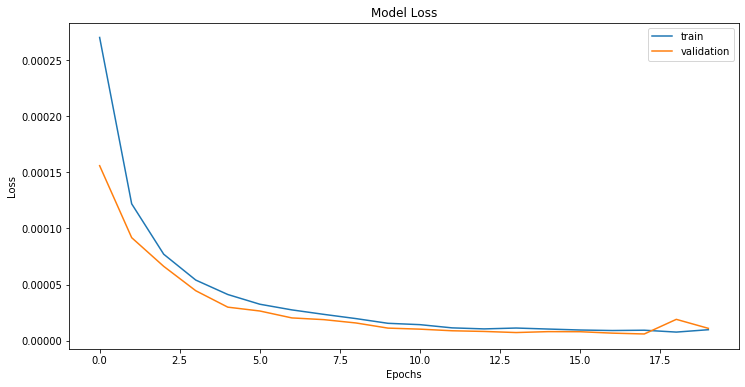

In [30]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()

## Word2Vec Model for Word Embeddings:

In [31]:
######## DEALING WITH KEYWORDS COLUMNS ############:

keywords_list = list(new_df['Keyword'])
cleaned_keyword_list = list()
for line in keywords_list:
    rem_token_punc = RegexpTokenizer(r'\w+')
    tokens = rem_token_punc.tokenize(line)
    # print(tokens)
    words = [w.lower() for w in tokens]
    # print(words)
    words = [word for word in words if not word in stopwords]
    # print(words)
    cleaned_keyword_list.append(words)
    
print(cleaned_keyword_list[:10])
print(len(cleaned_keyword_list))

EMB_dim = 32

# train Word2Vec model
model = gensim.models.Word2Vec(sentences = cleaned_keyword_list, size = EMB_dim, workers = 4, min_count = 1)
# vocabulary size
words = list(model.wv.vocab)
print("Here is the Vocabulary Size .. %d" % len(words))

[['lil', 'kim'], ['world', 'cup'], ['san', 'diego', 'dui', 'lawyer'], ['stock', 'images'], ['apply', 'credit', 'cards'], ['citifinancial'], ['lil', 'kim'], ['equity', 'loan', 'rates'], ['camcorders', 'camera'], ['degree']]
203595
Here is the Vocabulary Size .. 729


In [32]:
model.wv.most_similar("insurance")

[('tracking', 0.7874703407287598),
 ('21', 0.7512573003768921),
 ('assurance', 0.622692346572876),
 ('critical', 0.5895940065383911),
 ('quote', 0.5838733315467834),
 ('private', 0.5796915888786316),
 ('whole', 0.5615999698638916),
 ('term', 0.5520616173744202),
 ('plans', 0.5479406714439392),
 ('owners', 0.5463212728500366)]

In [33]:
card = model['card']

print(card)

[-1.1247857   0.5874214   0.36081704 -0.18142487  0.8397575   1.9041008
  0.4540054  -0.17217039  0.6587162   0.15736642 -2.1298223  -0.30249652
 -2.059311    2.4636073  -1.5106937   2.7907934  -1.1095431   0.08096094
 -1.6099793  -0.8938683   0.3160625   1.1057665  -1.5247617   0.1779569
 -0.07165117 -1.5879406  -1.4303409  -1.3157313   1.5187339   0.2972652
 -0.12954785 -0.8807036 ]


In [36]:
scaled_df.columns

Index(['Date', 'CPC', 'Market', 'CTR', 'Impressions', 'Cost', 'Clicks'], dtype='object')

In [42]:
inputA = Input(shape=(6,))
inputB = Input(shape=(724,))
 
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(8, activation="relu")(x)
x = Dense(8, activation = "relu")(x)
x = Dense(1, activation = "linear")(x)
x = Model(inputs=inputA, outputs=x)
 
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(16, activation="relu")(y)
y = Dense(4, activation = "linear")(y)
y = Model(inputs=inputB, outputs=y)
 
# combine the output of the two branches
combined = concatenate([x.output, y.output])
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(8, activation="relu")(combined)
z = Dense(8, activation="relu")(z)
z = Dense(8, activation = "relu")(z)
z = Dense(1, activation = "linear")(z)
 
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [43]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [44]:
history = model.fit([X_train, X_text_train], y_train,
                   validation_data = ([X_test, X_text_test], y_test), epochs = 20, batch_size = 64)

Train on 142516 samples, validate on 61079 samples
Epoch 1/20
142516/142516 [==============================] - 12s 86us/step - loss: 2835080.0930 - accuracy: 2.2454e-04 - val_loss: 1321992.9181 - val_accuracy: 8.1861e-05
Epoch 2/20
142516/142516 [==============================] - 12s 82us/step - loss: 855953.9600 - accuracy: 4.9117e-05 - val_loss: 555922.5004 - val_accuracy: 1.6372e-04
Epoch 3/20
142516/142516 [==============================] - 12s 82us/step - loss: 548754.9543 - accuracy: 1.4735e-04 - val_loss: 440662.4326 - val_accuracy: 8.1861e-05
Epoch 4/20
142516/142516 [==============================] - 12s 81us/step - loss: 422542.4697 - accuracy: 9.1218e-05 - val_loss: 382156.0289 - val_accuracy: 3.2744e-05
Epoch 5/20
142516/142516 [==============================] - 12s 81us/step - loss: 293361.5455 - accuracy: 9.1218e-05 - val_loss: 275304.2907 - val_accuracy: 1.6372e-05
Epoch 6/20
142516/142516 [==============================] - 12s 83us/step - loss: 202524.1856 - accuracy: 8

In [45]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

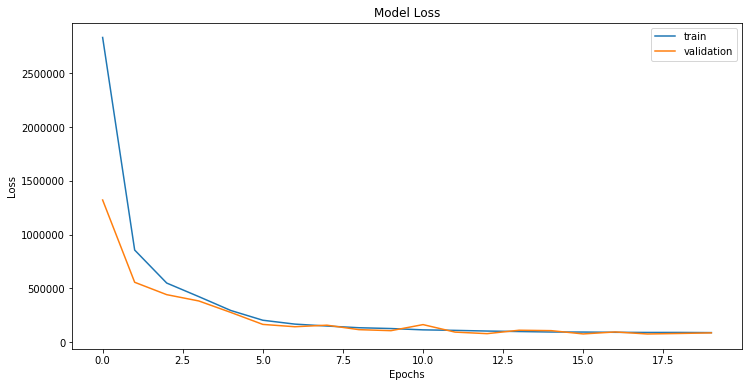

In [46]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()

## The TF-IDF Approach

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
corpus = list(new_df['Keyword'])
vectorizer = TfidfVectorizer()

tf_corpus = vectorizer.fit_transform(corpus)

# print(vectorizer.get_feature_names())
# print(len(vectorizer.get_feature_names()))

X_text = tf_corpus
y = new_df['Clicks']

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size = 0.3, random_state = 101)

print(X_text_train.shape)
print(y_train.shape)

model1 = Sequential()

model1.add(Dense(8, activation = "relu", input_dim = X_text_train.shape[1]))
model1.add(Dense(8, activation = "relu"))
model1.add(Dense(8, activation = "relu"))
model1.add(Dense(1, activation = "linear"))

model1.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])

(142516, 724)
(142516,)


In [38]:
history = model1.fit(x = X_text_train, y = y_train, batch_size = 64, epochs = 50,
         verbose = 1, validation_split = 0.2)

Train on 114012 samples, validate on 28504 samples
Epoch 1/50
114012/114012 [==============================] - 5s 47us/step - loss: 5037994.5182 - accuracy: 4.2101e-04 - val_loss: 4145988.0971 - val_accuracy: 3.5083e-05
Epoch 2/50
114012/114012 [==============================] - 5s 47us/step - loss: 4163965.8993 - accuracy: 1.1402e-04 - val_loss: 3360864.2422 - val_accuracy: 5.6132e-04
Epoch 3/50
114012/114012 [==============================] - 5s 47us/step - loss: 3445954.8107 - accuracy: 2.5436e-04 - val_loss: 2871596.5918 - val_accuracy: 1.4033e-04
Epoch 4/50
114012/114012 [==============================] - 5s 47us/step - loss: 2964276.9333 - accuracy: 2.5436e-04 - val_loss: 2593728.7538 - val_accuracy: 2.1050e-04
Epoch 5/50
114012/114012 [==============================] - 5s 47us/step - loss: 2696463.6689 - accuracy: 2.4559e-04 - val_loss: 2439633.3232 - val_accuracy: 1.0525e-04
Epoch 6/50
114012/114012 [==============================] - 5s 47us/step - loss: 2524556.9869 - accuracy

Epoch 49/50
114012/114012 [==============================] - 5s 45us/step - loss: 2111255.4322 - accuracy: 1.7542e-04 - val_loss: 1932879.4025 - val_accuracy: 2.1050e-04
Epoch 50/50
114012/114012 [==============================] - 5s 45us/step - loss: 2108141.0520 - accuracy: 1.5788e-04 - val_loss: 1932905.3424 - val_accuracy: 1.7541e-04


In [39]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

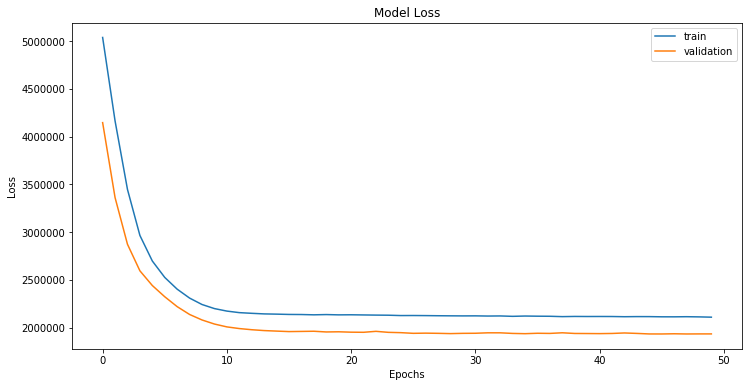

In [40]:
plt.figure(figsize = (12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc = 'upper_right')
plt.show()